In [1]:
#NOTE: use paimg1 env, the retccl one has package issue with torchvision
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles, get_feature_label_array_dynamic, get_feature_label_array_dynamic_nonoverlaptest
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction, BCE_WithRegularization
from Model import Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
####################################
######      USERINPUT       ########
####################################
SELECTED_MUTATION = "MT"
model_name = "MIL" #Chose from Linear, LinearMT
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
#SELECTED_FEATURE = [str(i) for i in range(0,2048)] + ['TUMOR_PIXEL_PERC']
SELECTED_FEATURE = [str(i) for i in range(0,2048)]
TUMOR_FRAC_THRES = 0
SAMPLE_SIZE = 1000
UPSAMP = True
##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
wsi_path = proj_dir + '/data/OPX/'
label_path = proj_dir + 'data/MutationCalls/'
model_path = proj_dir + 'models/feature_extraction_models/'
tile_path = proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL100/'
ft_ids_path =  proj_dir + 'intermediate_data/cd_finetune/cancer_detection_training/' #the ID used for fine-tuning cancer detection model, needs to be excluded from mutation study
feature_name = 'features_alltiles_nonoverlapretccl'
test_tile_path =  proj_dir + 'intermediate_data/cancer_prediction_results110224/IMSIZE250_OL0/'

if UPSAMP == False:
    out_folder_name = 'MAX_SS'+ str(SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE))
else:
    out_folder_name = 'UPSAMPED_ALL_SS'+ str(SAMPLE_SIZE) + '_NFEATURES' + str(len(SELECTED_FEATURE))

model_data_path = proj_dir + 'intermediate_data/model_ready_data/' + out_folder_name  + '/'
test_feature_name = 'test_features_nonoverlapretccl'

################################################
#Create output-dir
################################################
outdir0 =  proj_dir + "intermediate_data/pred_out/" + out_folder_name + "/"
outdir1 =  outdir0  + SELECTED_MUTATION + "/saved_model/" + model_name + "/"
outdir2 =  outdir0 + SELECTED_MUTATION + "/model_para/"
outdir3 =  outdir0 + SELECTED_MUTATION + "/logs/"
outdir4 =  outdir0 + SELECTED_MUTATION + "/predictions/"

create_dir_if_not_exists(outdir0)
create_dir_if_not_exists(outdir1)
create_dir_if_not_exists(outdir2)
create_dir_if_not_exists(outdir3)
create_dir_if_not_exists(outdir4)

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/saved_model/MIL/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/model_para/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/logs/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/' created.
cuda:0


In [4]:
################################################
#     Model ready data 
################################################
train_data = torch.load(model_data_path + 'train_data.pth')
test_data = torch.load(model_data_path + 'test_data.pth')
test_data2 = torch.load(model_data_path + 'test_data_nonoverlap_nonsampling.pth')
val_data = torch.load(model_data_path + 'val_data.pth')

test_ids = torch.load(model_data_path + 'test_ids.pth')
test_info2 = torch.load(model_data_path + 'test_info_nonoverlap_nonsampling.pth')

In [5]:
####################################################
#            Train 
####################################################
set_seed(0)
LEARNING_RATE = 0.00001
BATCH_SIZE  = 1
ACCUM_SIZE = 16  # Number of steps to accumulate gradients
EPOCHS = 500
DROPOUT = 0
N_OUTCOME = 7
DIM_OUT = 128
N_FEATURE = 2048
N_LABELS = len(SELECTED_LABEL)
LOSS_WEIGHTS_LIST = [[1, 100], [1, 100], [1, 100], [1, 100], [1, 100], [1, 10], [1, 20]]  #NEG, POS
REG_COEEF = 0.001
REG_TYPE = 'L1'

#Dataloader for training
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader2 = DataLoader(dataset=test_data2, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

Number of parameters: 3050504
Epoch0: Train-LOSS:339.94081, Valid-LOSS:300.42497
Epoch10: Train-LOSS:318.91501, Valid-LOSS:282.40873
Epoch20: Train-LOSS:289.23214, Valid-LOSS:262.83788
Epoch30: Train-LOSS:251.19915, Valid-LOSS:242.32473
Epoch40: Train-LOSS:230.83325, Valid-LOSS:228.54418
Epoch50: Train-LOSS:215.62601, Valid-LOSS:215.19447
Epoch60: Train-LOSS:201.59821, Valid-LOSS:201.84881
Epoch70: Train-LOSS:188.26865, Valid-LOSS:188.83817
Epoch80: Train-LOSS:175.55186, Valid-LOSS:176.30626
Epoch90: Train-LOSS:163.42819, Valid-LOSS:164.30860
Epoch100: Train-LOSS:151.89502, Valid-LOSS:152.86983
Epoch110: Train-LOSS:140.95089, Valid-LOSS:142.00076
Epoch120: Train-LOSS:130.60022, Valid-LOSS:131.71280
Epoch130: Train-LOSS:120.84770, Valid-LOSS:122.01390
Epoch140: Train-LOSS:111.70295, Valid-LOSS:112.91698
Epoch150: Train-LOSS:103.17086, Valid-LOSS:104.42877
Epoch160: Train-LOSS:95.25761, Valid-LOSS:96.55702
Epoch170: Train-LOSS:87.96616, Valid-LOSS:89.30539
Epoch180: Train-LOSS:81.30208, 

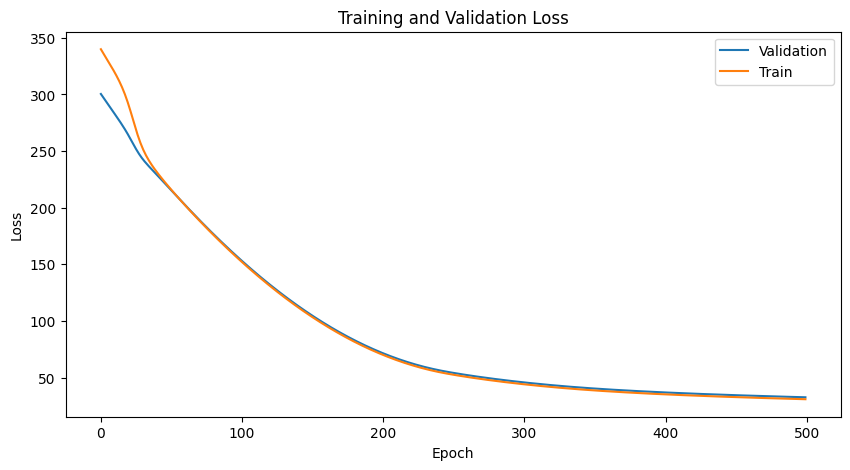

In [6]:
#Construct model
model = Mutation_MIL_MT(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_OUTCOME,
                        dim_out = DIM_OUT)
model.to(device)

#Optimizer
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Loss
loss_func = torch.nn.BCELoss()

#Model para
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
#print(model)


#OUTPUT MODEL hyper-para
hyper_df = pd.DataFrame({"Target_Mutation": SELECTED_MUTATION,
                        #"N_Train_Patches": train_df.shape[0],
                        #"N_Train_Features": train_df.shape[1]-1,
                        #"N_Validation_Patches": val_df.shape[0],
                        "BATCH_SIZE": BATCH_SIZE,
                        "ACCUM_SIZE": ACCUM_SIZE,
                        "N_EPOCH": EPOCHS,
                        "Learning_Rate": LEARNING_RATE,
                        "NUM_MODEL_PARA": total_params}, index = [0])
hyper_df.to_csv(outdir2 + "hyperpara_df.csv")


log_message("Start Training", outdir3 + "training_log.txt")


####################################################################################
#Training
####################################################################################
train_loss = []
valid_loss = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    ct = 0
    accumlation_loss = 0
    for x,y in train_loader:
        ct += 1
        optimizer.zero_grad() #zero the grad
        yhat_list, _ = model(x.to(device)) #Forward

        loss_list = []
        for i in range(0,N_LABELS):
            #cur_loss = loss_func(yhat_list[i],y[:,:,i].to(device))  #compute loss
            LOSS_WEIGHTS = LOSS_WEIGHTS_LIST[i]
            #print(LOSS_WEIGHTS)
            cur_loss = BCE_WithRegularization(yhat_list[i],y[:,:,i].to(device), REG_COEEF, REG_TYPE, model, LOSS_WEIGHTS, reduction = 'mean')
            loss_list.append(cur_loss) #compute loss
        #Sum loss for all labels
        loss = sum(loss_list)
        
        # for i in range(0,N_LABELS):
        #     if i != N_LABELS - 1:
        #         loss_list[i].backward(retain_graph=True)   #backward  
        #     else:
        #         loss_list[i].backward() 
        
        running_loss += loss.detach().item() #acuumalated batch loss
        accumlation_loss += loss 
       
        #Optimize
        if ct % ACCUM_SIZE == 0:
            accumlation_loss = accumlation_loss/ACCUM_SIZE
            accumlation_loss.backward() 
            optimizer.step()  # Optimize
            accumlation_loss = 0

    #Training loss 
    epoch_loss = running_loss/len(train_loader) #accumulated loss/total # batches (averaged loss over batches)
    train_loss.append(epoch_loss)

    #Validation
    model.eval()
    with torch.no_grad():
        val_running_loss = 0
        for x_val,y_val in val_loader:
            val_yhat_list, _ = model(x_val.to(device))
            
            val_loss_list = []
            for i in range(0,N_LABELS):
                #cur_val_loss = loss_func(val_yhat_list[i],y_val[:,:,i].to(device))  #compute loss
                LOSS_WEIGHTS = LOSS_WEIGHTS_LIST[i]
                cur_val_loss = BCE_WithRegularization(val_yhat_list[i],y_val[:,:,i].to(device), REG_COEEF, REG_TYPE, model, LOSS_WEIGHTS, reduction = 'mean')
                val_loss_list.append(cur_val_loss) 

            val_loss = sum(val_loss_list)
            val_running_loss += val_loss.detach().item() 
        val_epoch_loss = val_running_loss/len(val_loader) 
        valid_loss.append(val_epoch_loss)

    if epoch % 10 == 0:
        print("Epoch"+ str(epoch) + ":",
              "Train-LOSS:" + "{:.5f}".format(train_loss[epoch]) + ", " +
              "Valid-LOSS:" +  "{:.5f}".format(valid_loss[epoch]))
    
    #Save model parameters
    torch.save(model.state_dict(), outdir1 + "model" + str(epoch))


#Plot LOSS
plot_LOSS(train_loss,valid_loss, outdir1)
log_message("End Training", outdir3 + "training_log.txt")

In [7]:
####################################################################################
#Testing
####################################################################################
#Load model
min_index = valid_loss.index(min(valid_loss))
print(min_index)
#min_index = 499
model2 = Mutation_MIL_MT(in_features = N_FEATURE, act_func = 'tanh', drop_out = DROPOUT)
state_dict = torch.load(outdir1 + "model" + str(min_index))
model2.load_state_dict(state_dict)
model2.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.4

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction(test_loader2, model2, N_LABELS, loss_func, device, attention = True)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
   pred_df_list.append(pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                          "Y_True": [l[i] for l in test_true_label], 
                                          "Pred_Prob" :  [l[i] for l in test_pred_prob],
                                          "OUTCOME": SELECTED_LABEL[i]}))
pred_df = pd.concat(pred_df_list)

#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir0 + SELECTED_MUTATION + "/pred_df.csv",index = False)


#Compute performance
perf_df = compute_performance_each_label(SELECTED_LABEL, pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir0 + SELECTED_MUTATION + "/perf.csv",index = True)

print(perf_df.iloc[:,[0,5,6,7,8,9]])
print("AVG AUC:", round(perf_df['AUC'].mean(),2))
print("AVG PRAUC:", round(perf_df['PR_AUC'].mean(),2))
#Use regularization no dropout now has the best performance at avg AUC = 0.61

499
Test-Loss TOTAL: 11.44918
               AUC  Recall  Precision  Specificity    PR_AUC  \
SAMPLE_LEVEL  0.68    1.00       0.12         0.00  0.357762   
SAMPLE_LEVEL  0.75    1.00       0.15         0.00  0.311534   
SAMPLE_LEVEL  0.52    1.00       0.22         0.00  0.250844   
SAMPLE_LEVEL  0.58    1.00       0.10         0.00  0.224048   
SAMPLE_LEVEL  0.67    1.00       0.40         0.00  0.615220   
SAMPLE_LEVEL  0.70    0.00       0.00         1.00  0.256566   
SAMPLE_LEVEL  0.70    0.33       0.12         0.81  0.256566   

                                                       OUTCOME  
SAMPLE_LEVEL                                                AR  
SAMPLE_LEVEL  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL                                              PTEN  
SAMPLE_LEVEL                                               RB1  
SAMPLE_LEVEL                                              TP53  
SAMPLE_LEVEL                           TMB_HIGHorINTERMEDITATE  
SA

In [8]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 0
mag_extract = 20
limit_bounds = True
TOP_K = 5
pretrain_model_name = "retccl"
mag_target_prob = 2.5
smooth = False

In [9]:
selected_ids = test_ids
for i in range(len(selected_ids)):
    pt = selected_ids[i]
    print(pt)
    
    save_location =  outdir4  + pt + "/"
    create_dir_if_not_exists(save_location)
    
    _file = wsi_path + pt + ".tif"
    oslide = openslide.OpenSlide(_file)
    save_name = str(Path(os.path.basename(_file)).with_suffix(''))
    
    
    #Get a Attention, and corresponding tiles
    cur_pt_att = test_att[i]
    cur_pt_info = test_info2[i]
    cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
    
    
    
    #Generate tiles
    tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
    
    print('starting inference')
    #get level 0 size in px
    l0_w = oslide.level_dimensions[0][0]
    l0_h = oslide.level_dimensions[0][1]
    
    #2.5x for probability maps
    lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
    x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
    
    cur_att_df['pred_map_location'] = pd.NA
    for index, row in cur_att_df.iterrows():
        cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
        x ,y = int(cur_xy[0]) , int(cur_xy[1])
        
        #Extract tile for prediction
        lvl_in_deepzoom = tile_lvls.index(mag_extract)
        tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
        map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
        cur_att_df.loc[index,'pred_map_location'] = str(tuple([map_xstart, map_xend, map_ystart, map_yend]))
    
        #Store predicted probabily in map and count
        try: 
            x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
            x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
        except:
            pass
    
    print('post-processing')
    x_count = np.where(x_count < 1, 1, x_count)
    x_map = x_map / x_count
    x_map[x_map>1]=1

    if smooth == True:
        x_sm = filters.gaussian(x_map, sigma=2)
    if smooth == False:
        x_sm = x_map
    plt.imshow(x_sm, cmap='Spectral_r')
    plt.colorbar()
    plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
    plt.close()
    #plt.show()
    
    
    
    #Top attented tiles
    save_location2 = save_location + "top_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
    
    #Bot attented tiles
    save_location2 = save_location + "bot_tiles/"
    create_dir_if_not_exists(save_location2)
    
    #Get a Attention, and corresponding tiles
    cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
    cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
    
    for i in range(TOP_K):
        cur_pulled_img = cur_pulled_img_obj[i][0] #image
        cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
        cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
        coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
        tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
        cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

OPX_011
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/OPX_011/' created.
starting inference
post-processing
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/OPX_011/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/OPX_011/bot_tiles/' created.
OPX_017
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/OPX_017/' created.
starting inference
post-processing
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/MT/predictions/OPX_017/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out/UPSAMPED_ALL_SS1000_NFEATURES2048/